In [9]:
from __future__ import print_function
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pdb

class Helper(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []
        self.misclassified_images = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = Helper.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations normal
        train_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms

    @staticmethod
    def get_train_transforms_rotaion(mean=0.1307, std=0.3081):
        # Train Phase transformations with rotation
        train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean,), (std,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])
        return train_transforms

    @staticmethod
    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    @staticmethod
    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std

    # First step
    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = Helper.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = Helper.get_train_transforms_rotaion(mean, std)
        if test_transforms is None:
            test_transforms = Helper.get_test_transforms(mean, std)
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    def view_images(self, path='./data', num_of_images=60, display_log=True):
        # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
        print("The initial stastics:")
        train, test = self.get_train_test_data_set(path=path, display_log=True)
        train_data = train.train_data
        train_data = train.transform(train_data.numpy())

        print('Image data stastics')
        print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
        print(' - Tensor Shape:', train.train_data.size())
        print(' - min:', torch.min(train_data))
        print(' - max:', torch.max(train_data))
        print(' - mean:', torch.mean(train_data))
        print(' - std:', torch.std(train_data))
        print(' - var:', torch.var(train_data))

        train_loader, test_loader = self.get_data_loader(train, test, batch_size=128)
        dataiter = iter(train_loader)
        images, labels = dataiter.next()

        print(images.shape)
        print(labels.shape)

        plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
        print("")
        self.view_defined_images(images, num_of_images)


    def view_defined_images(self, images, num_of_images):
        figure = plt.figure()
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch, l1_factor=None):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #pdb.set_trace()
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #update l1 regularizer if requested
        if l1_factor:
          loss = self.apply_l1_regularizer(loss, model, l1_factor)

        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def update_misclassified_images(self, data, target, pred):
        target_change = target.view_as(pred)
        for i in range(len(pred)):
          if pred[i].item()!= target_change[i].item():
            self.misclassified_images.append([data[i], pred[i], target_change[i]])

    def test(self, model, device, test_loader, misclassfied_required=False):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                # update misclassified images if requested
                if misclassfied_required:
                   self.update_misclassified_images(data, target, pred)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))


    # second step
    def train_test_model(self, model, EPOCHS=20, batch_size=128, path='./data', optimizer=None, train_transforms=None, test_transforms=None, l1_factor=None, misclassfied_required=False):
        # Train and test our model
        if optimizer is None:
            optimizer = self.get_optimizer(model, lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path, train_transforms=train_transforms, test_transforms=test_transforms)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch, l1_factor=l1_factor)
            self.test(model, device, test_loader, misclassfied_required=misclassfied_required)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    @staticmethod
    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff

    def display_plot(self):
        try:
            fig, axs = plt.subplots(2,2,figsize=(15,10))
            axs[0, 0].plot(self.train_losses)
            axs[0, 0].set_title("Training Loss")
            axs[1, 0].plot(self.train_acc)
            axs[1, 0].set_title("Training Accuracy")
            axs[0, 1].plot(self.test_losses)
            axs[0, 1].set_title("Test Loss")
            axs[1, 1].plot(self.test_acc)
            axs[1, 1].set_title("Test Accuracy")
            #print('Train loss: ',self.train_min_loss)
            #print('Test loss: ',self.test_losses)
            #print("Difference in loss : ", Helper.calculate_diff(self.train_min_loss, self.test_losses))
            #print('Train Accuracy: ',self.train_max_acc)
            #print('Test Accuracy: ',self.test_acc)
            #print("Difference in Accuracy : ", Helper.calculate_diff(self.train_max_acc, self.test_acc))
            max_element = max(self.train_max_acc)
            print("Maximum Train accuracy : ",max_element)
            print("Test accuracy : ",max(self.test_acc))
        except Exception as e:
            print("First train the model")


    def get_optimizer(self, model, lr=0.01, momentum=0.9):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        return optimizer

    def get_step_optimizer(self, model, lr=0.01, momentum=0.9, step_size=1, gamma=0.1):
       optimizer = self.get_optimizer(model, lr, momentum)
       scheduler = StepLR(optimizer, step_size, gamma)
       return optimizer

    def apply_l1_regularizer(self, loss, model, l1_factor=0.0005):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        parameters = model.parameters()
        for param in parameters:
          reg_loss += torch.sum(param.abs())
        loss += l1_factor * reg_loss
        return loss

    def apply_l2_regularizer(self, model, weight_decay, lr=0.01, momentum=0.9):
        l2_regularizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        return l2_regularizer

    def plot_misclassified(self, image_count=25):
      fig = plt.figure(figsize = (15,15))
      for i in range(image_count):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(self.misclassified_images[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        sub.set_title("Predicted={0}, Actual={1}".format(str(self.misclassified_images[i][1].data.cpu().numpy()),str(self.misclassified_images[i][2].data.cpu().numpy())))       
      plt.tight_layout()
      plt.show()


    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            pass

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
#function which handles whether to apply BN or GBN
def norm2d(output_channels, batch_type="BN"):
    if batch_type == "GBN":
        num_splits = 8
        return GhostBatchNorm(output_channels,num_splits)
    else:
        return nn.BatchNorm2d(output_channels)

In [0]:
class Net(nn.Module):
    def __init__(self, batch_type="BN"):
        super(Net, self).__init__()
        p = 0.07
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 26, RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 24, RF=5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 22,  RF=7
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 22,  RF=7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF=8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 9, RF=10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            #nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 7, RF=14
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            #nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 7, RF=18
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1, RF=30

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8, RF=30

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

# 1.3.with L1 with BN

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 22, 22]           1,296
       BatchNorm2d-8           [-1, 12, 22, 22]              24
              ReLU-9           [-1, 12, 22, 22]               0
           Conv2d-10           [-1, 12, 22, 22]             144
      BatchNorm2d-11           [-1, 12, 22, 22]              24
             ReLU-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.3604922890663147 Batch_id=937 Accuracy=87.93: 100%|██████████| 938/938 [00:28<00:00, 33.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1058, Accuracy: 9716/10000 (97.16%)

EPOCH: 2


Train Set: Train Loss=0.25980162620544434 Batch_id=937 Accuracy=97.14: 100%|██████████| 938/938 [00:27<00:00, 33.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9705/10000 (97.05%)

EPOCH: 3


Train Set: Train Loss=0.23519404232501984 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:27<00:00, 34.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9810/10000 (98.10%)

EPOCH: 4


Train Set: Train Loss=0.24157032370567322 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:27<00:00, 34.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Train Set: Train Loss=0.23034195601940155 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:27<00:00, 33.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0958, Accuracy: 9684/10000 (96.84%)

EPOCH: 6


Train Set: Train Loss=0.19437739253044128 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:28<00:00, 33.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9796/10000 (97.96%)

EPOCH: 7


Train Set: Train Loss=0.2745744287967682 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:27<00:00, 33.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9796/10000 (97.96%)

EPOCH: 8


Train Set: Train Loss=0.20404589176177979 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:27<00:00, 34.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9775/10000 (97.75%)

EPOCH: 9


Train Set: Train Loss=0.2754218876361847 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:27<00:00, 34.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9789/10000 (97.89%)

EPOCH: 10


Train Set: Train Loss=0.2829045057296753 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:27<00:00, 34.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9843/10000 (98.43%)

EPOCH: 11


Train Set: Train Loss=0.17891444265842438 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:26<00:00, 35.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1094, Accuracy: 9597/10000 (95.97%)

EPOCH: 12


Train Set: Train Loss=0.20034581422805786 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:27<00:00, 34.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9797/10000 (97.97%)

EPOCH: 13


Train Set: Train Loss=0.18786203861236572 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:27<00:00, 34.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Train Set: Train Loss=0.3778129816055298 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:27<00:00, 34.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9852/10000 (98.52%)

EPOCH: 15


Train Set: Train Loss=0.28081274032592773 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:26<00:00, 34.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9826/10000 (98.26%)

EPOCH: 16


Train Set: Train Loss=0.18845395743846893 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:27<00:00, 34.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9847/10000 (98.47%)

EPOCH: 17


Train Set: Train Loss=0.20801563560962677 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:27<00:00, 34.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9818/10000 (98.18%)

EPOCH: 18


Train Set: Train Loss=0.23884952068328857 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:27<00:00, 34.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9822/10000 (98.22%)

EPOCH: 19


Train Set: Train Loss=0.18212252855300903 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:27<00:00, 34.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0945, Accuracy: 9702/10000 (97.02%)

EPOCH: 20


Train Set: Train Loss=0.2945367097854614 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:27<00:00, 34.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9775/10000 (97.75%)

EPOCH: 21


Train Set: Train Loss=0.33950644731521606 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:27<00:00, 34.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9802/10000 (98.02%)

EPOCH: 22


Train Set: Train Loss=0.1803307682275772 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:27<00:00, 34.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9845/10000 (98.45%)

EPOCH: 23


Train Set: Train Loss=0.15415650606155396 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:27<00:00, 34.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9877/10000 (98.77%)

EPOCH: 24


Train Set: Train Loss=0.2314019799232483 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:27<00:00, 34.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9773/10000 (97.73%)

EPOCH: 25


Train Set: Train Loss=0.23608167469501495 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:27<00:00, 33.91it/s]



Test set: Average loss: 0.1085, Accuracy: 9681/10000 (96.81%)

Maximum Train accuracy :  98.11
Test accuracy :  98.94


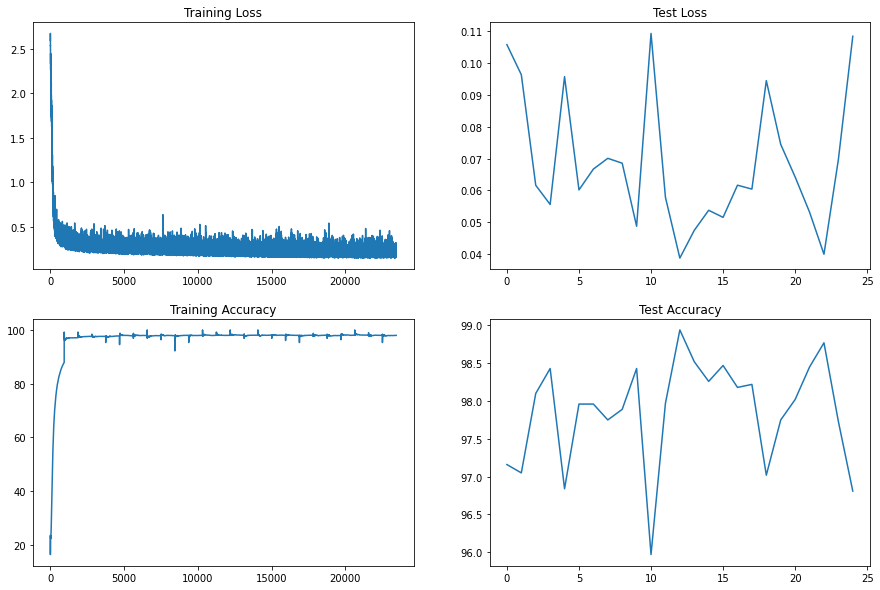

In [14]:
model3_l1_with_bn_loss = []
model3_l1_with_bn_accuracy = []
with Helper() as helper_obj:
  obj1 = Net()
  device = helper_obj.get_device()
  helper_obj.display_summary(obj1, 28)
  model =  obj1.to(device)
  helper_obj.train_test_model(model, EPOCHS=25, batch_size=64, l1_factor=0.0005)
  model3_l1_with_bn_loss.extend(helper_obj.test_losses)
  model3_l1_with_bn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()

# 1.4.with L1 with GBN

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 22, 22]           1,296
       BatchNorm2d-8           [-1, 12, 22, 22]              24
              ReLU-9           [-1, 12, 22, 22]               0
           Conv2d-10           [-1, 12, 22, 22]             144
      BatchNorm2d-11           [-1, 12, 22, 22]              24
             ReLU-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/235 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.5597784519195557 Batch_id=234 Accuracy=65.97: 100%|██████████| 235/235 [00:17<00:00, 13.77it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2597, Accuracy: 9508/10000 (95.08%)

EPOCH: 2


Train Set: Train Loss=0.4826183617115021 Batch_id=234 Accuracy=95.92: 100%|██████████| 235/235 [00:16<00:00, 13.85it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1139, Accuracy: 9709/10000 (97.09%)

EPOCH: 3


Train Set: Train Loss=0.3647429347038269 Batch_id=234 Accuracy=97.11: 100%|██████████| 235/235 [00:17<00:00, 13.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


Train Set: Train Loss=0.37217792868614197 Batch_id=234 Accuracy=97.51: 100%|██████████| 235/235 [00:16<00:00, 14.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1195, Accuracy: 9653/10000 (96.53%)

EPOCH: 5


Train Set: Train Loss=0.233534038066864 Batch_id=234 Accuracy=97.67: 100%|██████████| 235/235 [00:16<00:00, 14.01it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1206, Accuracy: 9663/10000 (96.63%)

EPOCH: 6


Train Set: Train Loss=0.24129676818847656 Batch_id=234 Accuracy=97.89: 100%|██████████| 235/235 [00:16<00:00, 14.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1131, Accuracy: 9664/10000 (96.64%)

EPOCH: 7


Train Set: Train Loss=0.24190843105316162 Batch_id=234 Accuracy=97.88: 100%|██████████| 235/235 [00:17<00:00, 13.75it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0789, Accuracy: 9769/10000 (97.69%)

EPOCH: 8


Train Set: Train Loss=0.24270522594451904 Batch_id=234 Accuracy=98.03: 100%|██████████| 235/235 [00:17<00:00, 13.81it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9859/10000 (98.59%)

EPOCH: 9


Train Set: Train Loss=0.2306698113679886 Batch_id=234 Accuracy=98.08: 100%|██████████| 235/235 [00:16<00:00, 14.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9868/10000 (98.68%)

EPOCH: 10


Train Set: Train Loss=0.28868600726127625 Batch_id=234 Accuracy=98.20: 100%|██████████| 235/235 [00:16<00:00, 14.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9850/10000 (98.50%)

EPOCH: 11


Train Set: Train Loss=0.2198375165462494 Batch_id=234 Accuracy=98.26: 100%|██████████| 235/235 [00:17<00:00, 13.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9829/10000 (98.29%)

EPOCH: 12


Train Set: Train Loss=0.22529688477516174 Batch_id=234 Accuracy=98.30: 100%|██████████| 235/235 [00:17<00:00, 13.78it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9882/10000 (98.82%)

EPOCH: 13


Train Set: Train Loss=0.21538040041923523 Batch_id=234 Accuracy=98.27: 100%|██████████| 235/235 [00:16<00:00, 13.86it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9782/10000 (97.82%)

EPOCH: 14


Train Set: Train Loss=0.22510755062103271 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [00:17<00:00, 13.77it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9774/10000 (97.74%)

EPOCH: 15


Train Set: Train Loss=0.33276212215423584 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [00:17<00:00, 13.72it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9854/10000 (98.54%)

EPOCH: 16


Train Set: Train Loss=0.21847401559352875 Batch_id=234 Accuracy=98.32: 100%|██████████| 235/235 [00:17<00:00, 13.74it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9868/10000 (98.68%)

EPOCH: 17


Train Set: Train Loss=0.30566003918647766 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:17<00:00, 13.67it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9861/10000 (98.61%)

EPOCH: 18


Train Set: Train Loss=0.22932636737823486 Batch_id=234 Accuracy=98.29: 100%|██████████| 235/235 [00:17<00:00, 13.66it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9894/10000 (98.94%)

EPOCH: 19


Train Set: Train Loss=0.27669990062713623 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [00:17<00:00, 13.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9848/10000 (98.48%)

EPOCH: 20


Train Set: Train Loss=0.22589102387428284 Batch_id=234 Accuracy=98.41: 100%|██████████| 235/235 [00:17<00:00, 13.76it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9858/10000 (98.58%)

EPOCH: 21


Train Set: Train Loss=0.26197871565818787 Batch_id=234 Accuracy=98.46: 100%|██████████| 235/235 [00:17<00:00, 13.58it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9884/10000 (98.84%)

EPOCH: 22


Train Set: Train Loss=0.2461317479610443 Batch_id=234 Accuracy=98.45: 100%|██████████| 235/235 [00:17<00:00, 13.76it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9904/10000 (99.04%)

EPOCH: 23


Train Set: Train Loss=0.1935858279466629 Batch_id=234 Accuracy=98.56: 100%|██████████| 235/235 [00:16<00:00, 14.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9863/10000 (98.63%)

EPOCH: 24


Train Set: Train Loss=0.21834084391593933 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [00:16<00:00, 14.06it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9873/10000 (98.73%)

EPOCH: 25


Train Set: Train Loss=0.21234536170959473 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [00:16<00:00, 14.07it/s]



Test set: Average loss: 0.0308, Accuracy: 9917/10000 (99.17%)

Maximum Train accuracy :  98.56
Test accuracy :  99.17


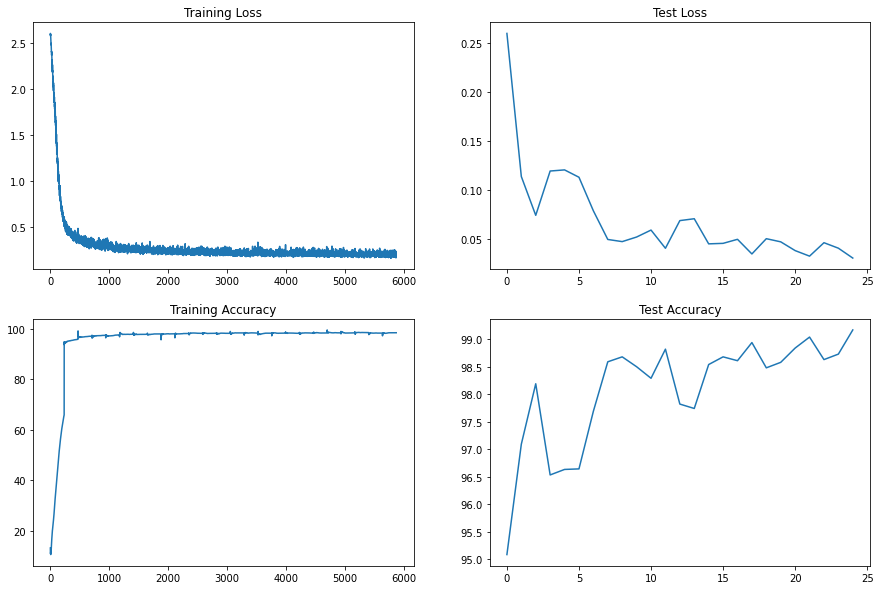

In [23]:
model4_l1_with_gbn_loss = []
model4_l1_with_gbn_accuracy = []
with Helper() as helper_obj:
  obj = Net(batch_type="GBN")
  device = helper_obj.get_device()
  helper_obj.display_summary(obj1, 28)
  model =  obj.to(device)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=256, l1_factor=0.0005)
  model4_l1_with_gbn_loss.extend(helper_obj.test_losses)
  model4_l1_with_gbn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()

# 1.5.with L2 with BN

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.0806078314781189 Batch_id=937 Accuracy=89.13: 100%|██████████| 938/938 [00:25<00:00, 37.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9813/10000 (98.13%)

EPOCH: 2


Train Set: Train Loss=0.024489492177963257 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:25<00:00, 37.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Train Set: Train Loss=0.11201058328151703 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:24<00:00, 38.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Train Set: Train Loss=0.05213286727666855 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:24<00:00, 38.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Train Set: Train Loss=0.027144551277160645 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:24<00:00, 38.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Train Set: Train Loss=0.003826245665550232 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:23<00:00, 39.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Train Set: Train Loss=0.052082642912864685 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:24<00:00, 38.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Train Set: Train Loss=0.03805899620056152 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:24<00:00, 38.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Train Set: Train Loss=0.04098750650882721 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:24<00:00, 38.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Train Set: Train Loss=0.035234540700912476 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:24<00:00, 38.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Train Set: Train Loss=0.005682766437530518 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:24<00:00, 38.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Train Set: Train Loss=0.008496865630149841 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:24<00:00, 38.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Train Set: Train Loss=0.01366223394870758 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:24<00:00, 39.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Train Set: Train Loss=0.04646614193916321 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:23<00:00, 39.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Train Set: Train Loss=0.04221677780151367 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:23<00:00, 39.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9902/10000 (99.02%)

EPOCH: 16


Train Set: Train Loss=0.002624601125717163 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:23<00:00, 39.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Train Set: Train Loss=0.02662530541419983 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:24<00:00, 38.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Train Set: Train Loss=0.005934789776802063 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:24<00:00, 38.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9918/10000 (99.18%)

EPOCH: 19


Train Set: Train Loss=0.02167067676782608 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:24<00:00, 38.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Train Set: Train Loss=0.0326046496629715 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:24<00:00, 38.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 21


Train Set: Train Loss=0.046505287289619446 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:24<00:00, 38.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Train Set: Train Loss=0.0037865787744522095 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:24<00:00, 38.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


Train Set: Train Loss=0.008202508091926575 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:24<00:00, 39.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Train Set: Train Loss=0.07610700279474258 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:24<00:00, 38.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 25


Train Set: Train Loss=0.002544790506362915 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:24<00:00, 38.27it/s]



Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

Maximum Train accuracy :  99.37
Test accuracy :  99.53


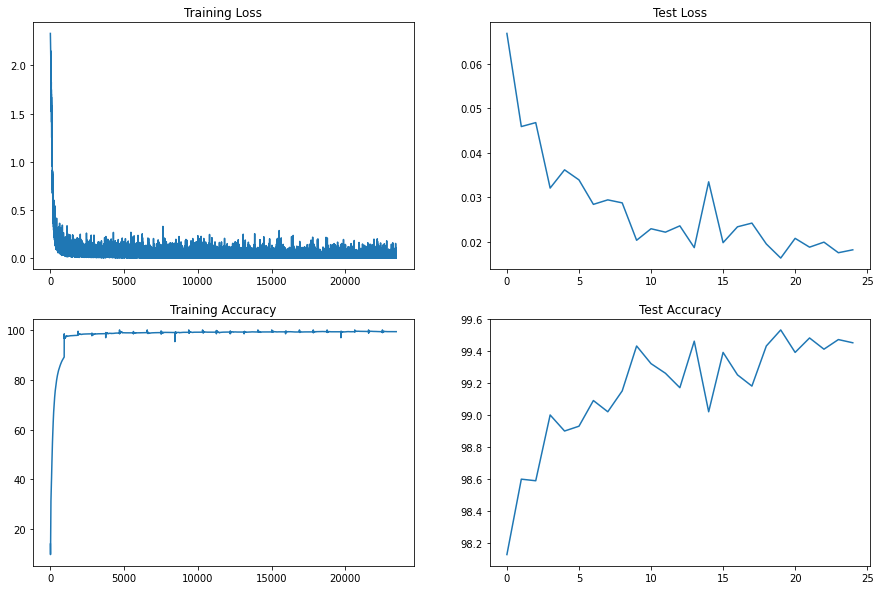

In [15]:
model5_l2_with_bn_loss = []
model5_l2_with_bn_accuracy = []
with Helper() as helper_obj:
  obj = Net()
  device = helper_obj.get_device()
  model =  obj.to(device)
  l2_regulizer  =  helper_obj.apply_l2_regularizer(model, 1e-4)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=64, optimizer=l2_regulizer)
  model5_l2_with_bn_loss.extend(helper_obj.test_losses)
  model5_l2_with_bn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()


# 1.6.with L2 with GBN

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/235 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.3850412368774414 Batch_id=234 Accuracy=68.93: 100%|██████████| 235/235 [00:16<00:00, 14.59it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2879, Accuracy: 9418/10000 (94.18%)

EPOCH: 2


Train Set: Train Loss=0.21064883470535278 Batch_id=234 Accuracy=95.48: 100%|██████████| 235/235 [00:16<00:00, 14.53it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1665, Accuracy: 9574/10000 (95.74%)

EPOCH: 3


Train Set: Train Loss=0.09886064380407333 Batch_id=234 Accuracy=96.96: 100%|██████████| 235/235 [00:16<00:00, 14.57it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9800/10000 (98.00%)

EPOCH: 4


Train Set: Train Loss=0.17597652971744537 Batch_id=234 Accuracy=97.61: 100%|██████████| 235/235 [00:16<00:00, 14.57it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0999, Accuracy: 9701/10000 (97.01%)

EPOCH: 5


Train Set: Train Loss=0.05522792413830757 Batch_id=234 Accuracy=97.92: 100%|██████████| 235/235 [00:16<00:00, 14.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0740, Accuracy: 9794/10000 (97.94%)

EPOCH: 6


Train Set: Train Loss=0.05816221609711647 Batch_id=234 Accuracy=98.21: 100%|██████████| 235/235 [00:16<00:00, 14.43it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9854/10000 (98.54%)

EPOCH: 7


Train Set: Train Loss=0.06698354333639145 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [00:16<00:00, 14.43it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Train Set: Train Loss=0.08933237195014954 Batch_id=234 Accuracy=98.41: 100%|██████████| 235/235 [00:16<00:00, 14.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9879/10000 (98.79%)

EPOCH: 9


Train Set: Train Loss=0.037228476256132126 Batch_id=234 Accuracy=98.53: 100%|██████████| 235/235 [00:16<00:00, 14.40it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Train Set: Train Loss=0.10345226526260376 Batch_id=234 Accuracy=98.58: 100%|██████████| 235/235 [00:16<00:00, 14.33it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Train Set: Train Loss=0.0706895962357521 Batch_id=234 Accuracy=98.68: 100%|██████████| 235/235 [00:16<00:00, 14.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Train Set: Train Loss=0.05764719471335411 Batch_id=234 Accuracy=98.75: 100%|██████████| 235/235 [00:16<00:00, 14.39it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Train Set: Train Loss=0.0491807758808136 Batch_id=234 Accuracy=98.81: 100%|██████████| 235/235 [00:16<00:00, 14.30it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9875/10000 (98.75%)

EPOCH: 14


Train Set: Train Loss=0.054475802928209305 Batch_id=234 Accuracy=98.82: 100%|██████████| 235/235 [00:16<00:00, 14.25it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9903/10000 (99.03%)

EPOCH: 15


Train Set: Train Loss=0.04074467346072197 Batch_id=234 Accuracy=98.94: 100%|██████████| 235/235 [00:16<00:00, 14.35it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9911/10000 (99.11%)

EPOCH: 16


Train Set: Train Loss=0.034369274973869324 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [00:16<00:00, 14.24it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Train Set: Train Loss=0.09561511129140854 Batch_id=234 Accuracy=98.92: 100%|██████████| 235/235 [00:16<00:00, 14.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH: 18


Train Set: Train Loss=0.037745121866464615 Batch_id=234 Accuracy=98.96: 100%|██████████| 235/235 [00:16<00:00, 14.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9918/10000 (99.18%)

EPOCH: 19


Train Set: Train Loss=0.11663313955068588 Batch_id=234 Accuracy=99.01: 100%|██████████| 235/235 [00:16<00:00, 14.34it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9925/10000 (99.25%)

EPOCH: 20


Train Set: Train Loss=0.03350004181265831 Batch_id=234 Accuracy=99.06: 100%|██████████| 235/235 [00:16<00:00, 14.25it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9885/10000 (98.85%)

EPOCH: 21


Train Set: Train Loss=0.022247647866606712 Batch_id=234 Accuracy=99.05: 100%|██████████| 235/235 [00:16<00:00, 14.29it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.19%)

EPOCH: 22


Train Set: Train Loss=0.037904899567365646 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:16<00:00, 14.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Train Set: Train Loss=0.01604672707617283 Batch_id=234 Accuracy=99.09: 100%|██████████| 235/235 [00:16<00:00, 14.16it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Train Set: Train Loss=0.03731011226773262 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:16<00:00, 14.17it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.09%)

EPOCH: 25


Train Set: Train Loss=0.006964127067476511 Batch_id=234 Accuracy=99.17: 100%|██████████| 235/235 [00:16<00:00, 14.25it/s]



Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

Maximum Train accuracy :  99.17
Test accuracy :  99.31


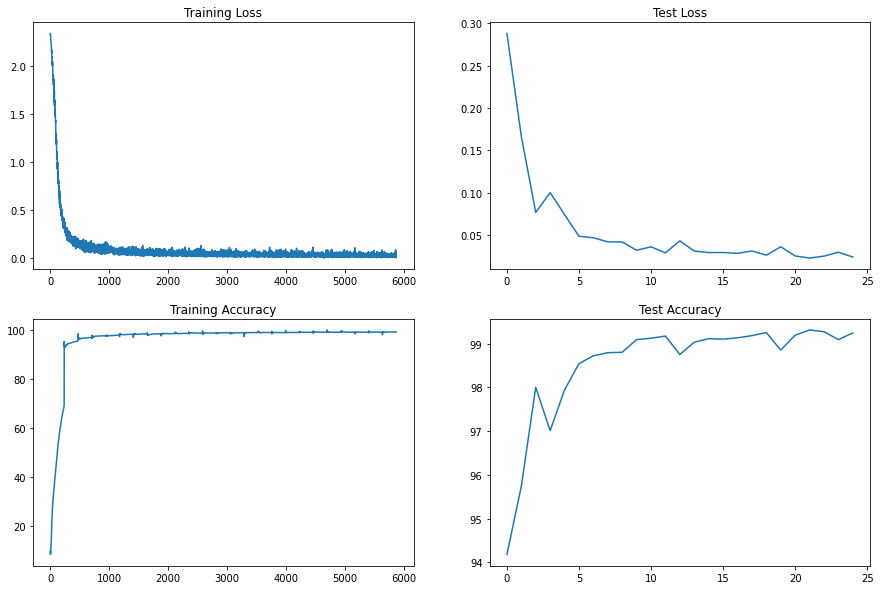

In [25]:
model6_l2_with_gbn_loss = []
model6_l2_with_gbn_accuracy = []
with Helper() as helper_obj:
  obj = Net(batch_type="GBN")
  device = helper_obj.get_device()
  model =  obj.to(device)
  l2_regulizer  =  helper_obj.apply_l2_regularizer(model, 1e-4)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=256, optimizer=l2_regulizer)
  model6_l2_with_gbn_loss.extend(helper_obj.test_losses)
  model6_l2_with_gbn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()

#  1.7.with L1 and L2 with BN

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.4035720229148865 Batch_id=937 Accuracy=89.05: 100%|██████████| 938/938 [00:29<00:00, 31.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0939, Accuracy: 9732/10000 (97.32%)

EPOCH: 2


Train Set: Train Loss=0.2903430461883545 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:28<00:00, 32.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1434, Accuracy: 9488/10000 (94.88%)

EPOCH: 3


Train Set: Train Loss=0.2442619353532791 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:28<00:00, 32.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1047, Accuracy: 9689/10000 (96.89%)

EPOCH: 4


Train Set: Train Loss=0.2895766496658325 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:28<00:00, 32.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9813/10000 (98.13%)

EPOCH: 5


Train Set: Train Loss=0.21837931871414185 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:28<00:00, 32.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Train Set: Train Loss=0.20113998651504517 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:28<00:00, 32.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9782/10000 (97.82%)

EPOCH: 7


Train Set: Train Loss=0.28931379318237305 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:28<00:00, 32.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9781/10000 (97.81%)

EPOCH: 8


Train Set: Train Loss=0.33510634303092957 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:28<00:00, 32.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9806/10000 (98.06%)

EPOCH: 9


Train Set: Train Loss=0.26120156049728394 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:28<00:00, 32.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9807/10000 (98.07%)

EPOCH: 10


Train Set: Train Loss=0.20558010041713715 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:29<00:00, 32.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9861/10000 (98.61%)

EPOCH: 11


Train Set: Train Loss=0.18257738649845123 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:28<00:00, 32.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9841/10000 (98.41%)

EPOCH: 12


Train Set: Train Loss=0.314065158367157 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:28<00:00, 32.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Train Set: Train Loss=0.19691182672977448 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:28<00:00, 32.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9791/10000 (97.91%)

EPOCH: 14


Train Set: Train Loss=0.3828848898410797 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:28<00:00, 32.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9773/10000 (97.73%)

EPOCH: 15


Train Set: Train Loss=0.2965235412120819 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:28<00:00, 33.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9868/10000 (98.68%)

EPOCH: 16


Train Set: Train Loss=0.18858684599399567 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:28<00:00, 33.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

EPOCH: 17


Train Set: Train Loss=0.22638030350208282 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:28<00:00, 32.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0780, Accuracy: 9744/10000 (97.44%)

EPOCH: 18


Train Set: Train Loss=0.248587965965271 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:28<00:00, 33.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9847/10000 (98.47%)

EPOCH: 19


Train Set: Train Loss=0.18264909088611603 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:28<00:00, 33.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9771/10000 (97.71%)

EPOCH: 20


Train Set: Train Loss=0.3704054653644562 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:28<00:00, 33.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9808/10000 (98.08%)

EPOCH: 21


Train Set: Train Loss=0.2272339016199112 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:28<00:00, 32.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9874/10000 (98.74%)

EPOCH: 22


Train Set: Train Loss=0.17338886857032776 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:28<00:00, 33.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9815/10000 (98.15%)

EPOCH: 23


Train Set: Train Loss=0.19925811886787415 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:28<00:00, 32.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9864/10000 (98.64%)

EPOCH: 24


Train Set: Train Loss=0.19139611721038818 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:27<00:00, 33.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9782/10000 (97.82%)

EPOCH: 25


Train Set: Train Loss=0.176188126206398 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:27<00:00, 33.85it/s]



Test set: Average loss: 0.0518, Accuracy: 9852/10000 (98.52%)

Maximum Train accuracy :  98.06
Test accuracy :  98.87


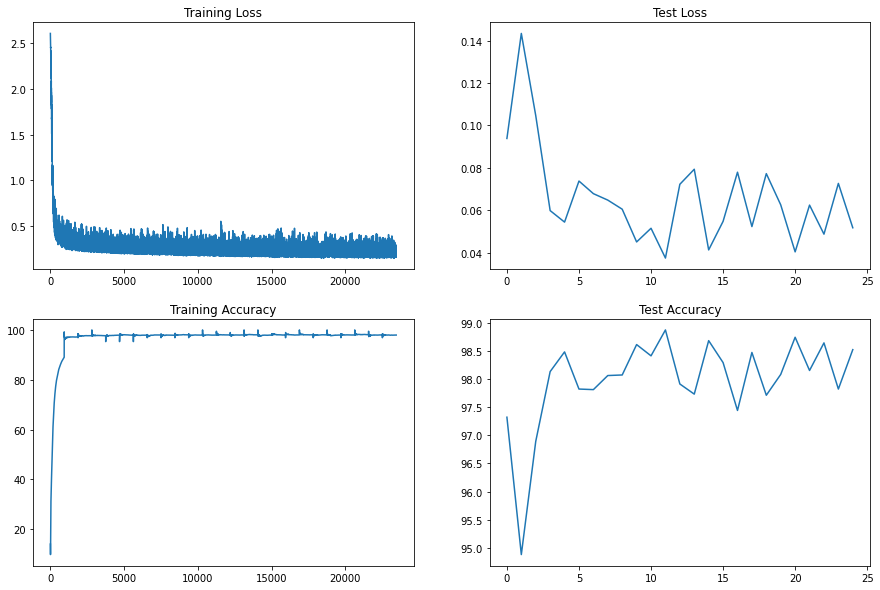

In [27]:
model7_l1_l2_with_bn_loss = []
model7_l1_l2_with_bn_accuracy = []
with Helper() as helper_obj:
  obj = Net()
  device = helper_obj.get_device()
  #helper_obj.display_summary(obj1, 28)
  model =  obj.to(device)
  l2_regulizer  =  helper_obj.apply_l2_regularizer(model, 1e-4)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=64, l1_factor=0.0005, optimizer=l2_regulizer)
  model7_l1_l2_with_bn_loss.extend(helper_obj.test_losses)
  model7_l1_l2_with_bn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()

# 1.8.with L1 and L2 with GBN

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/235 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.6267088651657104 Batch_id=234 Accuracy=69.31: 100%|██████████| 235/235 [00:17<00:00, 13.63it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.3208, Accuracy: 9351/10000 (93.51%)

EPOCH: 2


Train Set: Train Loss=0.42476886510849 Batch_id=234 Accuracy=95.68: 100%|██████████| 235/235 [00:17<00:00, 13.44it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2176, Accuracy: 9397/10000 (93.97%)

EPOCH: 3


Train Set: Train Loss=0.317836731672287 Batch_id=234 Accuracy=97.14: 100%|██████████| 235/235 [00:16<00:00, 13.90it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1541, Accuracy: 9549/10000 (95.49%)

EPOCH: 4


Train Set: Train Loss=0.3862766623497009 Batch_id=234 Accuracy=97.52: 100%|██████████| 235/235 [00:16<00:00, 13.91it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2052, Accuracy: 9364/10000 (93.64%)

EPOCH: 5


Train Set: Train Loss=0.2450835108757019 Batch_id=234 Accuracy=97.84: 100%|██████████| 235/235 [00:16<00:00, 13.86it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9818/10000 (98.18%)

EPOCH: 6


Train Set: Train Loss=0.27136045694351196 Batch_id=234 Accuracy=98.00: 100%|██████████| 235/235 [00:16<00:00, 13.89it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1501, Accuracy: 9541/10000 (95.41%)

EPOCH: 7


Train Set: Train Loss=0.2588976323604584 Batch_id=234 Accuracy=98.04: 100%|██████████| 235/235 [00:17<00:00, 13.60it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1395, Accuracy: 9591/10000 (95.91%)

EPOCH: 8


Train Set: Train Loss=0.258619487285614 Batch_id=234 Accuracy=98.08: 100%|██████████| 235/235 [00:16<00:00, 13.96it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9780/10000 (97.80%)

EPOCH: 9


Train Set: Train Loss=0.25262534618377686 Batch_id=234 Accuracy=98.13: 100%|██████████| 235/235 [00:17<00:00, 13.75it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9872/10000 (98.72%)

EPOCH: 10


Train Set: Train Loss=0.270135760307312 Batch_id=234 Accuracy=98.24: 100%|██████████| 235/235 [00:17<00:00, 13.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9864/10000 (98.64%)

EPOCH: 11


Train Set: Train Loss=0.24463722109794617 Batch_id=234 Accuracy=98.23: 100%|██████████| 235/235 [00:17<00:00, 13.60it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9762/10000 (97.62%)

EPOCH: 12


Train Set: Train Loss=0.23404675722122192 Batch_id=234 Accuracy=98.21: 100%|██████████| 235/235 [00:17<00:00, 13.71it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9808/10000 (98.08%)

EPOCH: 13


Train Set: Train Loss=0.21884530782699585 Batch_id=234 Accuracy=98.27: 100%|██████████| 235/235 [00:17<00:00, 13.34it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0561, Accuracy: 9825/10000 (98.25%)

EPOCH: 14


Train Set: Train Loss=0.28070586919784546 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:17<00:00, 13.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9813/10000 (98.13%)

EPOCH: 15


Train Set: Train Loss=0.247004896402359 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [00:17<00:00, 13.49it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9866/10000 (98.66%)

EPOCH: 16


Train Set: Train Loss=0.20825377106666565 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [00:17<00:00, 13.60it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9850/10000 (98.50%)

EPOCH: 17


Train Set: Train Loss=0.2687745988368988 Batch_id=234 Accuracy=98.39: 100%|██████████| 235/235 [00:17<00:00, 13.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9873/10000 (98.73%)

EPOCH: 18


Train Set: Train Loss=0.18452483415603638 Batch_id=234 Accuracy=98.26: 100%|██████████| 235/235 [00:17<00:00, 13.43it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9832/10000 (98.32%)

EPOCH: 19


Train Set: Train Loss=0.31801092624664307 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [00:17<00:00, 13.44it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9844/10000 (98.44%)

EPOCH: 20


Train Set: Train Loss=0.21603193879127502 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:17<00:00, 13.32it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0852, Accuracy: 9753/10000 (97.53%)

EPOCH: 21


Train Set: Train Loss=0.212785542011261 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [00:17<00:00, 13.48it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9830/10000 (98.30%)

EPOCH: 22


Train Set: Train Loss=0.24963481724262238 Batch_id=234 Accuracy=98.45: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 9791/10000 (97.91%)

EPOCH: 23


Train Set: Train Loss=0.17068016529083252 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [00:17<00:00, 13.33it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9790/10000 (97.90%)

EPOCH: 24


Train Set: Train Loss=0.21467728912830353 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [00:17<00:00, 13.44it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9890/10000 (98.90%)

EPOCH: 25


Train Set: Train Loss=0.19069260358810425 Batch_id=234 Accuracy=98.48: 100%|██████████| 235/235 [00:17<00:00, 13.36it/s]



Test set: Average loss: 0.0454, Accuracy: 9851/10000 (98.51%)

Maximum Train accuracy :  98.5
Test accuracy :  98.9


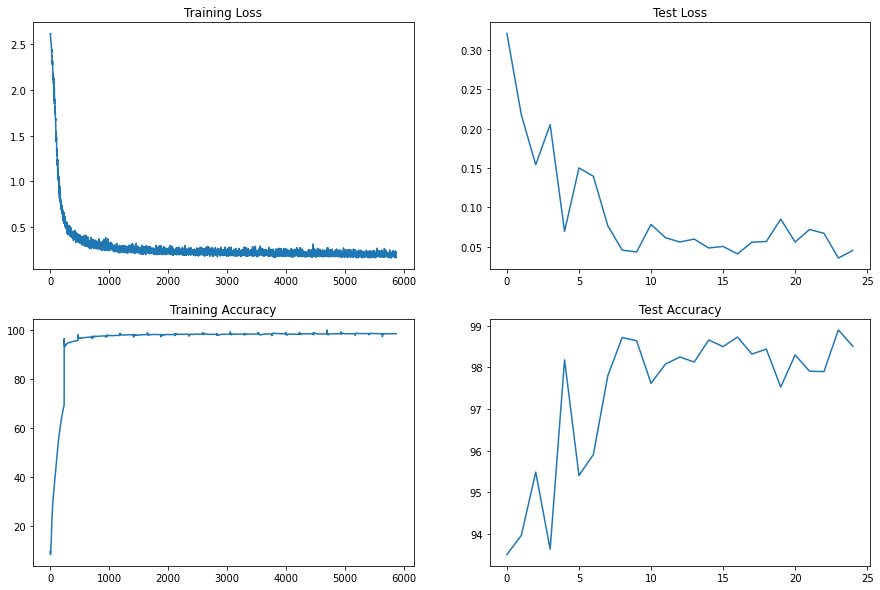

In [31]:
model8_l1_l2_with_gbn_loss = []
model8_l1_l2_with_gbn_accuracy = []
with Helper() as helper_obj:
  obj = Net(batch_type="GBN")
  device = helper_obj.get_device()
  #helper_obj4.display_summary(obj1, 28)
  model =  obj.to(device)
  l2_regulizer  =  helper_obj.apply_l2_regularizer(model, 1e-4)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=256, l1_factor=0.0005, optimizer=l2_regulizer)
  model8_l1_l2_with_gbn_loss.extend(helper_obj.test_losses)
  model8_l1_l2_with_gbn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()

## 1.1 without L1/L2 with BN
## 6. Display 25 misclassified images for "without L1/L2 with BN"

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.12235771119594574 Batch_id=937 Accuracy=89.13: 100%|██████████| 938/938 [00:24<00:00, 38.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Train Set: Train Loss=0.04781860113143921 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:24<00:00, 38.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Train Set: Train Loss=0.07131476700305939 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:24<00:00, 38.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9843/10000 (98.43%)

EPOCH: 4


Train Set: Train Loss=0.008036941289901733 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:24<00:00, 38.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Train Set: Train Loss=0.02109542489051819 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:24<00:00, 38.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Train Set: Train Loss=0.003189265727996826 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:24<00:00, 38.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Train Set: Train Loss=0.11699940264225006 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:24<00:00, 38.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Train Set: Train Loss=0.05348793417215347 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:24<00:00, 38.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9882/10000 (98.82%)

EPOCH: 9


Train Set: Train Loss=0.05301116406917572 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:24<00:00, 38.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Train Set: Train Loss=0.040543943643569946 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:24<00:00, 38.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Train Set: Train Loss=0.0047942399978637695 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Train Set: Train Loss=0.006946071982383728 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:24<00:00, 38.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Train Set: Train Loss=0.018102332949638367 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:24<00:00, 38.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Train Set: Train Loss=0.07331027090549469 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:24<00:00, 38.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Train Set: Train Loss=0.013600349426269531 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:24<00:00, 38.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Train Set: Train Loss=0.0014951974153518677 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:24<00:00, 38.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Train Set: Train Loss=0.021396860480308533 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:24<00:00, 38.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Train Set: Train Loss=0.0026195496320724487 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:24<00:00, 38.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9903/10000 (99.03%)

EPOCH: 19


Train Set: Train Loss=0.006249487400054932 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:24<00:00, 38.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9910/10000 (99.10%)

EPOCH: 20


Train Set: Train Loss=0.03763899207115173 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:24<00:00, 38.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Train Set: Train Loss=0.011227026581764221 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:24<00:00, 38.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Train Set: Train Loss=0.005910813808441162 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:24<00:00, 39.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Train Set: Train Loss=0.0010389387607574463 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:24<00:00, 38.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Train Set: Train Loss=0.043187230825424194 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:24<00:00, 38.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Train Set: Train Loss=0.001813441514968872 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:24<00:00, 38.28it/s]



Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

Maximum Train accuracy :  99.43
Test accuracy :  99.46


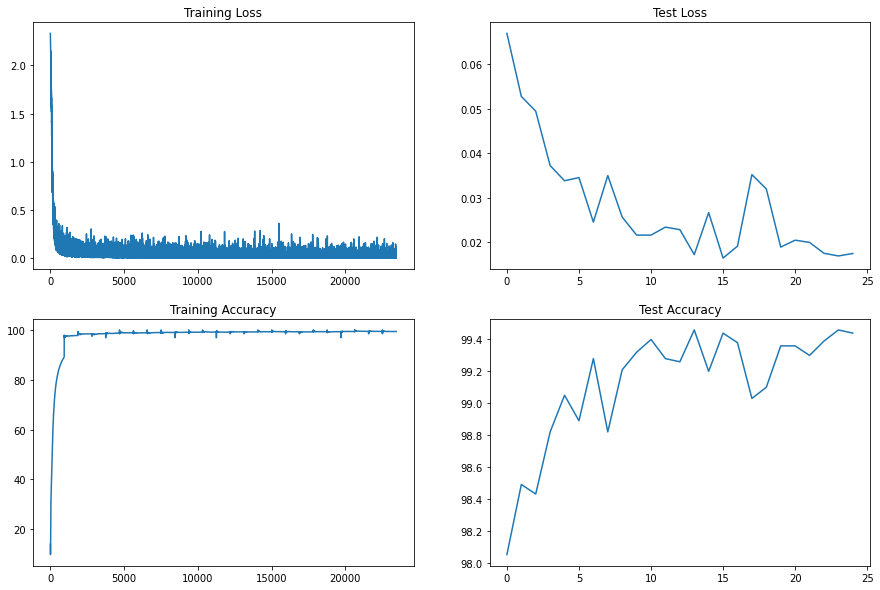

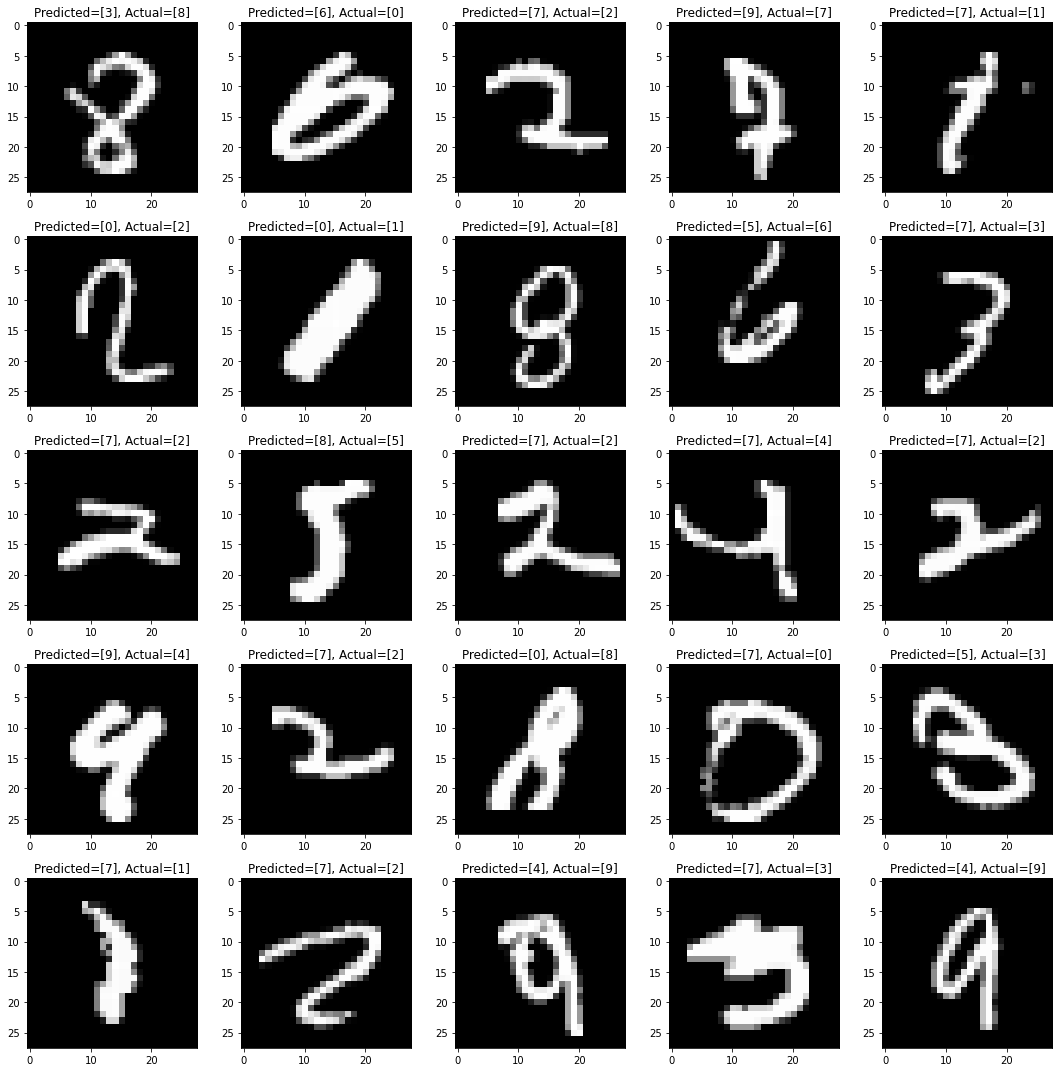

In [33]:
model1_with_bn_loss = []
model1_with_bn_accuracy = []
with Helper() as helper_obj:
  obj = Net()
  device = helper_obj.get_device()
  #helper_obj4.display_summary(obj1, 28)
  model =  obj.to(device)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=64, misclassfied_required=True)
  model1_with_bn_loss.extend(helper_obj.test_losses)
  model1_with_bn_accuracy.extend(helper_obj.test_acc) 
  helper_obj.display_plot()
  helper_obj.plot_misclassified()

## 1.2. without L1/L2 with GBN
## 6. Display 25 misclassified images for "without L1/L2 with GBN"

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/235 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.3885105848312378 Batch_id=234 Accuracy=68.99: 100%|██████████| 235/235 [00:16<00:00, 13.89it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.3109, Accuracy: 9351/10000 (93.51%)

EPOCH: 2


Train Set: Train Loss=0.22660647332668304 Batch_id=234 Accuracy=95.48: 100%|██████████| 235/235 [00:16<00:00, 14.31it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1717, Accuracy: 9536/10000 (95.36%)

EPOCH: 3


Train Set: Train Loss=0.09663035720586777 Batch_id=234 Accuracy=96.96: 100%|██████████| 235/235 [00:16<00:00, 14.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9823/10000 (98.23%)

EPOCH: 4


Train Set: Train Loss=0.17772091925144196 Batch_id=234 Accuracy=97.63: 100%|██████████| 235/235 [00:16<00:00, 14.30it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0913, Accuracy: 9725/10000 (97.25%)

EPOCH: 5


Train Set: Train Loss=0.060098063200712204 Batch_id=234 Accuracy=97.88: 100%|██████████| 235/235 [00:17<00:00, 13.78it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Train Set: Train Loss=0.05761740729212761 Batch_id=234 Accuracy=98.23: 100%|██████████| 235/235 [00:16<00:00, 14.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9847/10000 (98.47%)

EPOCH: 7


Train Set: Train Loss=0.05147113278508186 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [00:15<00:00, 14.70it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Train Set: Train Loss=0.07108805328607559 Batch_id=234 Accuracy=98.41: 100%|██████████| 235/235 [00:15<00:00, 14.70it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Train Set: Train Loss=0.030330682173371315 Batch_id=234 Accuracy=98.59: 100%|██████████| 235/235 [00:15<00:00, 14.69it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Train Set: Train Loss=0.13877929747104645 Batch_id=234 Accuracy=98.63: 100%|██████████| 235/235 [00:16<00:00, 14.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Train Set: Train Loss=0.06549286097288132 Batch_id=234 Accuracy=98.76: 100%|██████████| 235/235 [00:16<00:00, 14.35it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Train Set: Train Loss=0.056753307580947876 Batch_id=234 Accuracy=98.75: 100%|██████████| 235/235 [00:16<00:00, 14.54it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Train Set: Train Loss=0.040945250540971756 Batch_id=234 Accuracy=98.83: 100%|██████████| 235/235 [00:16<00:00, 14.33it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Train Set: Train Loss=0.0618915818631649 Batch_id=234 Accuracy=98.90: 100%|██████████| 235/235 [00:16<00:00, 14.49it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Train Set: Train Loss=0.028080781921744347 Batch_id=234 Accuracy=98.93: 100%|██████████| 235/235 [00:16<00:00, 14.24it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 16


Train Set: Train Loss=0.040564775466918945 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [00:16<00:00, 14.54it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9916/10000 (99.16%)

EPOCH: 17


Train Set: Train Loss=0.10336276143789291 Batch_id=234 Accuracy=98.94: 100%|██████████| 235/235 [00:16<00:00, 14.54it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 18


Train Set: Train Loss=0.02763986587524414 Batch_id=234 Accuracy=98.98: 100%|██████████| 235/235 [00:16<00:00, 14.58it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9899/10000 (98.99%)

EPOCH: 19


Train Set: Train Loss=0.09128937870264053 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:16<00:00, 14.65it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

EPOCH: 20


Train Set: Train Loss=0.02999086119234562 Batch_id=234 Accuracy=99.09: 100%|██████████| 235/235 [00:16<00:00, 14.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9898/10000 (98.98%)

EPOCH: 21


Train Set: Train Loss=0.025373339653015137 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:16<00:00, 14.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)

EPOCH: 22


Train Set: Train Loss=0.029027054086327553 Batch_id=234 Accuracy=99.09: 100%|██████████| 235/235 [00:16<00:00, 14.25it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

EPOCH: 23


Train Set: Train Loss=0.017239630222320557 Batch_id=234 Accuracy=99.14: 100%|██████████| 235/235 [00:16<00:00, 14.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9928/10000 (99.28%)

EPOCH: 24


Train Set: Train Loss=0.02382679283618927 Batch_id=234 Accuracy=99.13: 100%|██████████| 235/235 [00:16<00:00, 14.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9920/10000 (99.20%)

EPOCH: 25


Train Set: Train Loss=0.009692986495792866 Batch_id=234 Accuracy=99.19: 100%|██████████| 235/235 [00:16<00:00, 14.32it/s]



Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

Maximum Train accuracy :  99.19
Test accuracy :  99.28


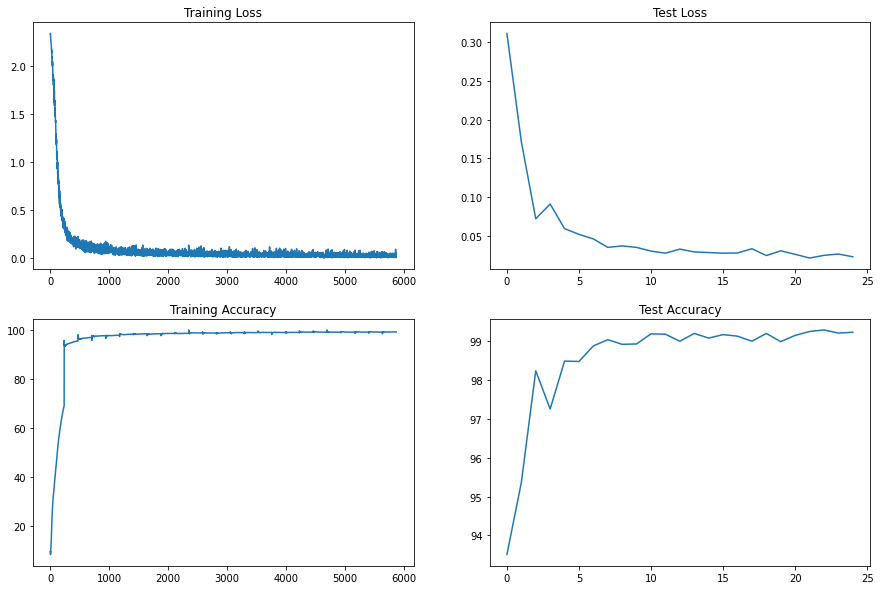

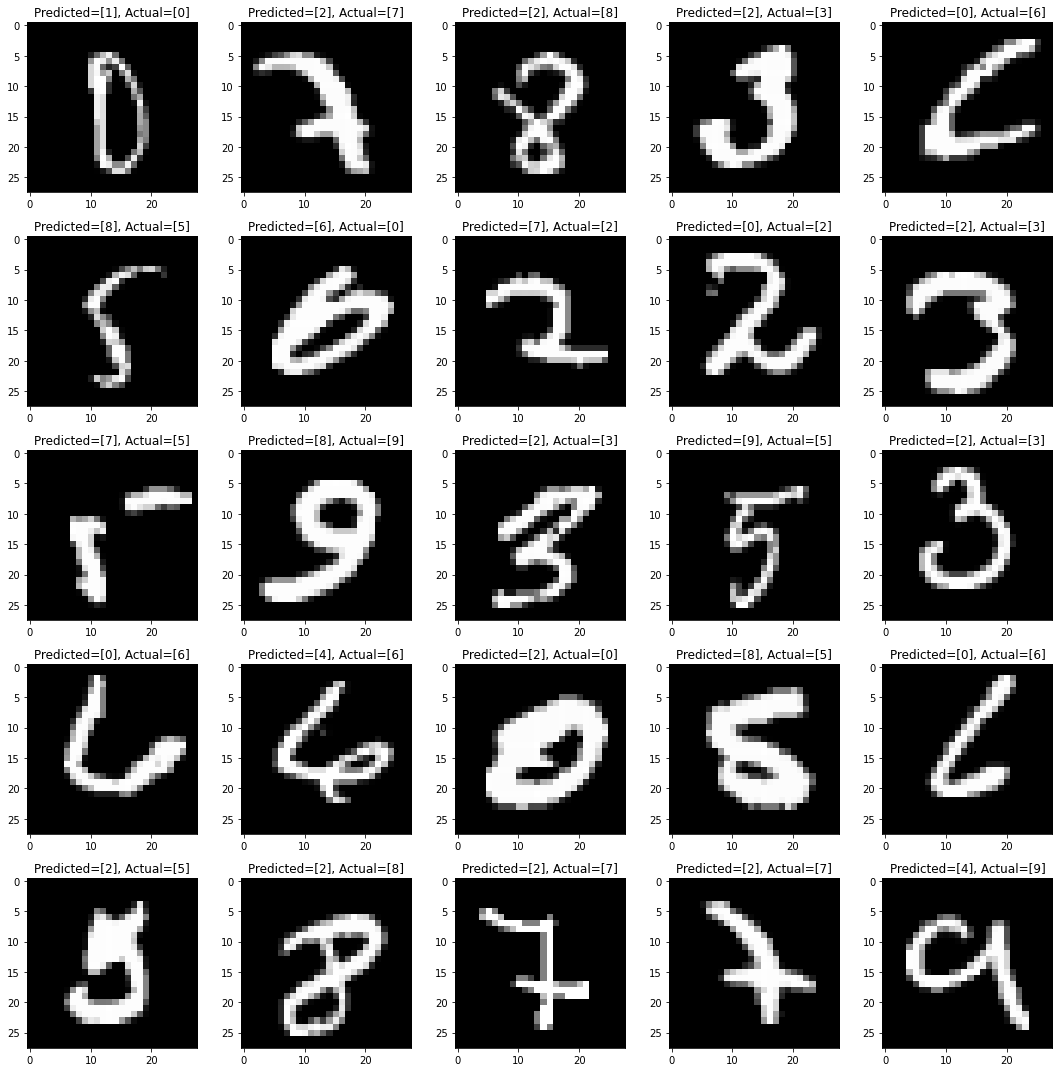

In [34]:
model2_with_gbn_loss = []
model2_with_gbn_accuracy = []
with Helper() as helper_obj:
  obj = Net(batch_type="GBN")
  device = helper_obj.get_device()
  #helper_obj4.display_summary(obj1, 28)
  model =  obj.to(device)
  helper_obj.train_test_model(obj, EPOCHS=25, batch_size=256, misclassfied_required=True)
  model2_with_gbn_loss.extend(helper_obj.test_losses)
  model2_with_gbn_accuracy.extend(helper_obj.test_acc)
  helper_obj.display_plot()
  helper_obj.plot_misclassified()


# 4. ONE graph to show the validation accuracy change curves for all 8 models

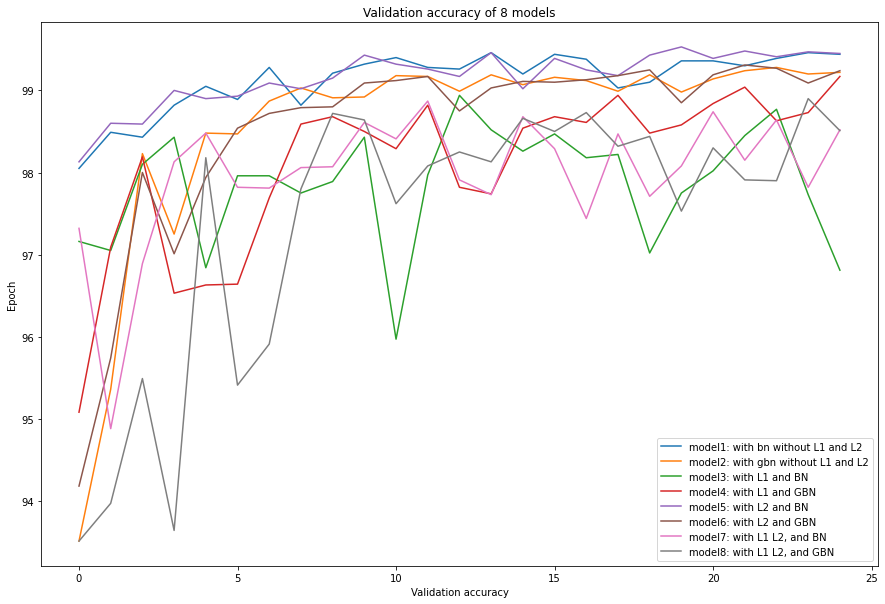

In [37]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1_with_bn_accuracy)
ax.plot(model2_with_gbn_accuracy)
ax.plot(model3_l1_with_bn_accuracy)
ax.plot(model4_l1_with_gbn_accuracy)
ax.plot(model5_l2_with_bn_accuracy)
ax.plot(model6_l2_with_gbn_accuracy)
ax.plot(model7_l1_l2_with_bn_accuracy)
ax.plot(model8_l1_l2_with_gbn_accuracy)
ax.set(title="Validation accuracy of 8 models", xlabel="Validation accuracy", ylabel="Epoch")
ax.legend(['model1: with bn without L1 and L2', 'model2: with gbn without L1 and L2', 'model3: with L1 and BN', 'model4: with L1 and GBN', 
            'model5: with L2 and BN',  'model6: with L2 and GBN',  'model7: with L1 L2, and BN', 'model8: with L1 L2, and GBN'], loc='best')
plt.savefig("validation_accuracy.png")
plt.show()

# 5. ONE graph to show the validation loss change curves for all 8 models

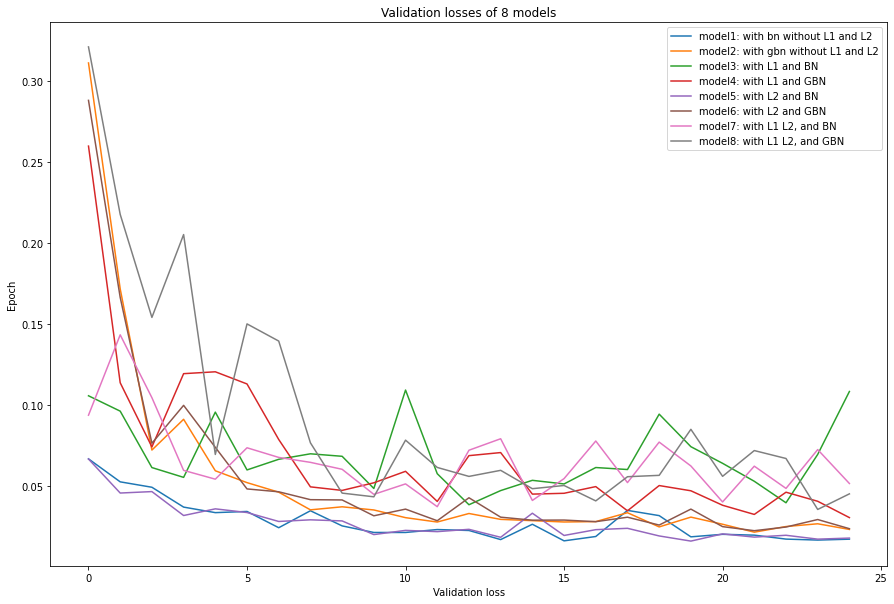

In [39]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1_with_bn_loss)
ax.plot(model2_with_gbn_loss)
ax.plot(model3_l1_with_bn_loss)
ax.plot(model4_l1_with_gbn_loss)
ax.plot(model5_l2_with_bn_loss)
ax.plot(model6_l2_with_gbn_loss)
ax.plot(model7_l1_l2_with_bn_loss)
ax.plot(model8_l1_l2_with_gbn_loss )
ax.set(title="Validation losses of 8 models", xlabel="Validation loss", ylabel="Epoch")
ax.legend(['model1: with bn without L1 and L2', 'model2: with gbn without L1 and L2', 'model3: with L1 and BN', 'model4: with L1 and GBN', 
            'model5: with L2 and BN',  'model6: with L2 and GBN',  'model7: with L1 L2, and BN', 'model8: with L1 L2, and GBN'], loc='best')
plt.savefig("validation_loss.png")
plt.show()

In [40]:
print(model1_with_bn_loss)
print(model1_with_bn_accuracy)

print(model2_with_gbn_loss)
print(model2_with_gbn_accuracy)

print(model3_l1_with_bn_loss)
print(model3_l1_with_bn_accuracy)

print(model4_l1_with_gbn_loss)
print(model4_l1_with_gbn_accuracy)

print(model5_l2_with_bn_loss)
print(model5_l2_with_bn_accuracy)

print(model6_l2_with_gbn_loss)
print(model6_l2_with_gbn_accuracy)

print(model7_l1_l2_with_bn_loss)
print(model7_l1_l2_with_bn_accuracy)

print(model8_l1_l2_with_gbn_loss)
print(model8_l1_l2_with_gbn_accuracy)

[0.06695354285240174, 0.05278742983341217, 0.049455258274078366, 0.03722673935890198, 0.03381573483943939, 0.0345340425491333, 0.02451742858886719, 0.034980131125450134, 0.025648112297058104, 0.021588788652420043, 0.02159339828491211, 0.023390604424476623, 0.0228172949552536, 0.017208359074592592, 0.02664819049835205, 0.01642944004535675, 0.01910692367553711, 0.03519926915168762, 0.03197758612632751, 0.018898104357719422, 0.02045648481845856, 0.01994316201210022, 0.017505754351615905, 0.0169046648979187, 0.017455544209480287]
[98.05, 98.49, 98.43, 98.82, 99.05, 98.89, 99.28, 98.82, 99.21, 99.32, 99.4, 99.28, 99.26, 99.46, 99.2, 99.44, 99.38, 99.03, 99.1, 99.36, 99.36, 99.3, 99.39, 99.46, 99.44]
[0.3109420446395874, 0.1716977463722229, 0.07237299556732178, 0.09134374647140503, 0.05961846749782562, 0.052304632759094236, 0.04641031370162964, 0.035531493020057675, 0.0374094952583313, 0.03546190228462219, 0.030719113755226134, 0.028025447607040406, 0.033280952668190006, 0.02966274280548096,

In [0]:
# 